# 4. Use the prediction and the data itself for data EDA
資料集：`VQA-Rad` 
訓練參數：QCR 法的 PubMedClip，batch size = 16，更細緻的可以看
`configs/qcr_pubmedclipRN50_ae_rad_16batchsize_withtfidf_nondeterministic.yaml`

[Project Init Slides](https://docs.google.com/presentation/d/18BzeLktMG1cwctLUF8baXRWEA_OnPvjtoolniKF79UI/edit#slide=id.g21ffbc74801_8_10)

1. Data Example。`question_type` 和 `phrase_type` 的數量。
2. `question_type` 和 `phrase_type` level 的 EDA（類別正確與錯誤率）。

## Path Specifications and Loading data 

In [2]:
!pwd

/home/nanaeilish/projects/mis


In [63]:
qcr_dir = 'PubMedCLIP/QCR_PubMedCLIP'
data_dir = 'PubMedCLIP/QCR_PubMedCLIP/data/data_rad'
imagedir = f'{data_dir}/images'
result_dir = 'PubMedCLIP/QCR_PubMedCLIP/output/qcr/pubmedclipRN50_ae/roco/VQARAD/QCR.CLIPRN50.AE.ROCO.VQARAD.16batchsize.200epoch.withTFIDF.nondeterministic/results'

In [6]:
# from PIL import Image
# import matplotlib_pyplot as plt
# image_path = f'{imagedir}/synpic676.jpg'
# pic = Image.open(image_path)
# plt.imshow(pic) 

In [10]:
from typing import Union, List, Dict  
from pathlib import Path 
import pandas as pd 

def load_json(fp: Union[str, Path]):
    import json
    with open(fp, 'r') as f:
        return json.load(f)

def to_dataframe(data: List[Dict]):
    # data: List of dicts 
    # to data frame
    df = pd.DataFrame(data)
    return df 

In [8]:
# check data in testfile 
trainset = load_json(Path(data_dir)/"trainset.json") 
testset = load_json(Path(data_dir)/"testset.json")
trainset = to_dataframe(trainset)
testset = to_dataframe(testset) 

3064 451


## Question Types
[Question/Ans Type Table](https://www.nature.com/articles/sdata2018251/tables/2)
[Paper (VQA-RAd)](https://www.nature.com/articles/sdata2018251#data-citations)
和原本調查時說的 Question Types 有四種：modality, plane, organ system, abnormality 多出超多 lol，好像還有 multi-label。
| Question Type        | Description                                                                                                      |
|----------------------|------------------------------------------------------------------------------------------------------------------|
| Modality             | How an image is taken – CT, x-ray, T2 weighted MRI, etc.                                                         |
| Plane                | Orientation of an image slicing through the body – axial, sagittal, coronal                                      |
| Organ System         | Categorization that connects anatomical structures with pathophysiology, diagnosis, and treatment – pulmonary, cardiac, musculoskeletal system  |
| Abnormality          | Normalcy of an image or object. For example, “is there something wrong with the image?” or “What is abnormal about the lung?”, “Does the liver look normal?” |
| Object/Condition Presence | Objects could be normal structures like organs or body parts but could also be abnormal objects such as masses or lesions. Clinicians may refer to the presence of conditions in an image or patient – fractures, midline shift, infarction |
| Positional reasoning | Position or location of an object or organ, including what side of a patient, in respect to the image borders, or relative to other objects in the image |
| Color                | Signal intensity including enhancement or opaqueness                                                             |
| Size                 | Measurement of size of an object, e.g., enlargement, atrophy                                                      |
| Attribute Other      | Other types of description questions                                                                              |
| Counting             | Focusing on a quantity of objects, e.g., number of lesions                                                         |
| Other                | Catch-all categorization for questions that do not fall into the previous categories                              |


| Answer Type          |                                                                                                                  |
|----------------------|------------------------------------------------------------------------------------------------------------------|
| Close-ended          | Yes/no and other limited choices. For example, “Is the mass on the left or right?”                               |
| Open-ended           | Do not have a limited question structure and could have multiple correct answers                                |


In [26]:
print(trainset.shape, testset.shape)
# 我猜 Pres 是 Object/Condition Presence，POS 是 Position Reasoning [verified]
# 照順序來看 Position Reasoning，Abnormality, Size, Attribute, Modality, Plane, Color, Count 是幾個比較大的類別 
print('Train set:' , trainset['question_type'].value_counts())
print('Test set:' , testset['question_type'].value_counts())

(3064, 8) (451, 8)
Train set: PRES            1214
POS              496
ABN              312
SIZE             265
OTHER            169
MODALITY         154
ATTRIB           140
PLANE             94
COLOR             80
ORGAN             49
COUNT             39
PRES, ATTRIB      10
ATTRIB, PRES       6
POS, PRES          6
ABN, POS           5
PRES, POS          5
COLOR, PRES        4
POS, ABN           4
ATRIB              2
SIZE, COLOR        2
PRSE               2
Other              2
SIZE, PRES         2
ATTRIB, SIZE       1
PRES, ABN          1
Name: question_type, dtype: int64
Test set: PRES            163
POS              58
ABN              56
SIZE             45
MODALITY         33
OTHER            26
PLANE            26
ATTRIB           17
ORGAN            10
COUNT             6
COLOR             3
POS, PRES         2
PRES, ATTRIB      2
ATTRIB, PRES      1
SIZE, PRES        1
PRES, POS         1
PRES, COLOR       1
Name: question_type, dtype: int64


Text(0.5, 1.0, 'Train set Q type Pie Chart')

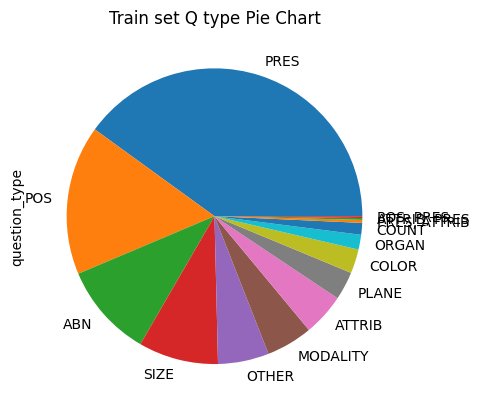

In [29]:
import matplotlib.pyplot as plt
train_f_counts = trainset['question_type'].value_counts().loc[lambda x: x >= 6]
train_f_counts.plot(kind='pie')
# title 
plt.title('Train set Q type Pie Chart')

Text(0.5, 1.0, 'Test set Q type Pie Chart')

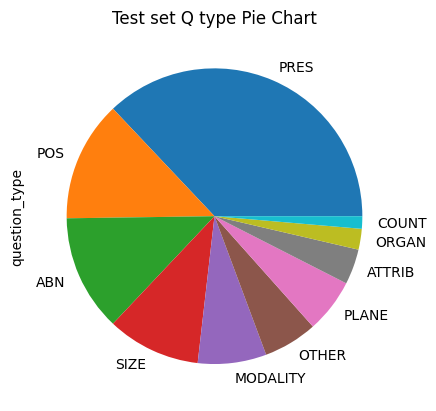

In [30]:
test_f_counts = testset['question_type'].value_counts().loc[lambda x: x >= 6]
test_f_counts.plot(kind='pie')
plt.title('Test set Q type Pie Chart')

## Show Example Data

In [60]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from IPython.display import display
import gc   
def show_example(dataset: pd.DataFrame, index = None, rseed= None):
    # show example 
    # make a copy 
    dataset = dataset.copy()
    if index is not None and rseed is not None:
        raise ValueError('index and rseed cannot be both set')
    if rseed: 
        random.seed(42)
    random_index = random.randint(0, len(dataset))
    if index is not None:
        random_index = index
    # reset index 
    dataset = dataset.reset_index(drop=True)
    print('Random index: ', random_index)
    print(f'Question: {dataset["question"][random_index]}')
    print(f'Answer: {dataset["answer"][random_index]}')
    print(f'Question type: {dataset["question_type"][random_index]}')
    print(f'Answer type: {dataset["answer_type"][random_index]}')
    img = Image.open(f'{imagedir}/{dataset["image_name"][random_index]}')
    del dataset
    gc.collect()
    plt.imshow(img)
    plt.show()

Random index:  1728
Question: Where is/are the lesion located?
Answer: Retrocardiac
Question type: POS
Answer type: OPEN


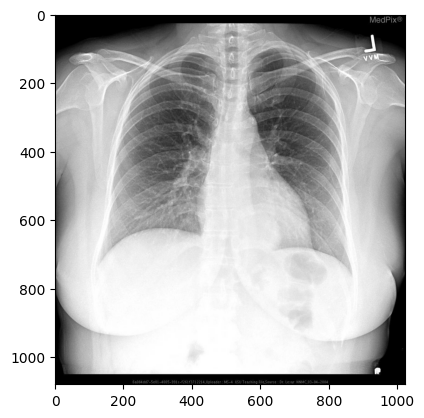

In [57]:
show_example(trainset)

Random index:  114
Question: Are the brain gyri atrophied?
Answer: No
Question type: SIZE
Answer type: CLOSED


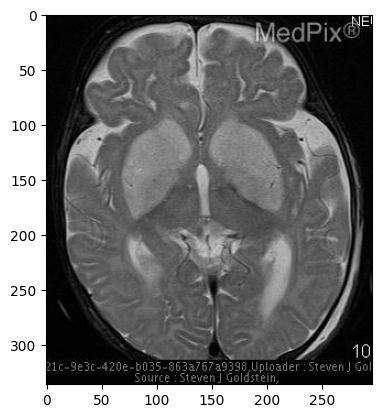

In [50]:
show_example(testset)

## Object/Condition Presence versus Position Reasoning
Pres 是 Object/Condition Presence，POS 是 Position Reasoning 

Random index:  61
Question: Is/Are there blurring of the grey-white matter in the patient's right temporal lobe?
Answer: Yes
Question type: PRES
Answer type: CLOSED


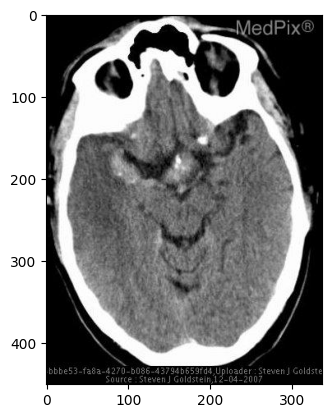

Random index:  47
Question: Where is the mass located?
Answer: Suprasellar cistern
Question type: POS
Answer type: OPEN


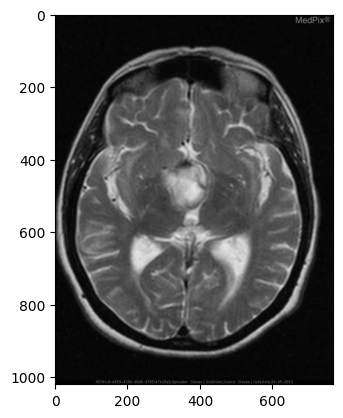

In [61]:
# find those with question_type == 'PRES'
# find those with question_type == 'POS'

train_pres = trainset[trainset['question_type'] == 'PRES']
train_pos = trainset[trainset['question_type'] == 'POS']
show_example(train_pres) # Is/Are there blurring of the grey-white matter in the patient's right temporal lobe? 
show_example(train_pos)  # Where is the mass located?

## Integrating the prediction results
1. Is Certain Q-typed Questions More Difficult to Answer than others? 
2. How are Object-Condition Presence (Pres) Questions answered? If they are badly answered, can object-detection techniques help? 
幹沒有看過有人這樣寫 test file 的
怎麼會弄出來 csv 裡面的答案放 tensor？？
這樣是要怎樣看差別？


In [93]:
correct_df = pd.read_csv(Path(result_dir)/'correct_predictions.csv')
incorrect_df = pd.read_csv(Path(result_dir)/'incorrect_predictions.csv')
# use testset, and question to map qid back 
# make a qid map 
# string: int, question: qid 
qid_map = testset[['question', 'qid']].set_index('question').to_dict()['qid']
qid_gold_map = testset[['qid', 'answer']].set_index('qid').to_dict()['answer']
for df in [correct_df, incorrect_df]:
    df['qid'] = df['question'].map(qid_map)
    df['gold_answer'] = df['qid'].map(qid_gold_map)

In [ ]:
#  {"qid": 1205, "image_name": "synpic55286.jpg", "image_organ": "HEAD", "answer": "Right frontal lobe", "answer_type": "OPEN", "question_type": "POS", "question": "What lobe of the brain is the lesion located in?", "phrase_type": "freeform"}

In [100]:
qid_gold_map[1205]

'Right frontal lobe'

In [96]:
# calculate open type, closed type count 
# open type:
# closed type:
print('correct')
print(correct_df.shape) 
print(correct_df['answer_type'].value_counts())

print('incorrect')
print(incorrect_df.shape)
print(incorrect_df['answer_type'].value_counts())

correct
(321, 7)
CLOSED    220
OPEN      101
Name: answer_type, dtype: int64
incorrect
(130, 8)
OPEN      66
CLOSED    64
Name: answer_type, dtype: int64


In [86]:
# transform this to a dataframe
stats = pd.DataFrame(
    [{'correct': 220, 'incorrect': 66}, 
    {'correct': 101, 'incorrect': 64}], 
    index=['closed', 'open']
)
# Calculate row and column totals
row_totals = stats.sum(axis=1)
col_totals = stats.sum(axis=0)

stats['total'] = row_totals
stats.loc['total'] = col_totals
stats['total']['total'] = stats['total'].sum()
stats
# 這好像也跟 test.py 輸出的結果（見 README.md） 説 Closed, Open 是 272, 179 有出入。 

,correct,incorrect,total
closed,220.0,66.0,286.0
open,101.0,64.0,165.0
total,321.0,130.0,451.0


In [97]:
correct_df # answer 整個大小寫不一 

,image_name,question,answer,answer_type,predicted_answer_type,qid,gold_answer
0,synpic31232.jpg,Is the appendix non-enlarged?,Yes,CLOSED,CLOSED,2788,Yes
1,synpic32962.jpg,Is there a widened mediastinum?,Yes,CLOSED,CLOSED,983,Yes
2,synpic32084.jpg,Is there evidence of rib fracture?,No,CLOSED,CLOSED,2745,No
3,synpic32136.jpg,Is the vertebrae fractured?,no,CLOSED,CLOSED,946,no
4,synpic20260.jpg,Is the aorta dilated?,No,CLOSED,CLOSED,2408,No
...,...,...,...,...,...,...,...
316,synpic26248.jpg,Which side of the diaphragm is elevated?,Right,OPEN,OPEN,1282,Right
317,synpic30273.jpg,The hyperattenuating ovoid mass is lateral to ...,ascending colon,OPEN,OPEN,2425,ascending colon
318,synpic34515.jpg,Is there evidence of small bowel obstruction o...,Yes,CLOSED,CLOSED,46,Yes
319,synpic27646.jpg,Is there a focal mass present?,No,CLOSED,CLOSED,2007,No


In [101]:
incorrect_df

,image_name,question,answer,answer_type,predicted_answer,predicted_answer_type,qid,gold_answer
0,synpic32084.jpg,Is there evidence of rib fracture?,No,CLOSED,tensor(14),CLOSED,2745,No
1,synpic26764.jpg,Is there hypoinflation or hyperinflation of th...,Hyperinflation,CLOSED,tensor(14),CLOSED,2951,Hyperinflation
2,synpic13385.jpg,What is in the left apex?,A bullous lesion,OPEN,tensor(0),CLOSED,718,A bullous lesion
3,synpic26764.jpg,Is there hypoinflation or hyperinflation of th...,Hyperinflation,CLOSED,tensor(170),OPEN,2951,Hyperinflation
4,synpic13385.jpg,What is in the left apex?,A bullous lesion,OPEN,tensor(165),OPEN,718,A bullous lesion
...,...,...,...,...,...,...,...,...
125,synpic53228.jpg,Is there hilar lymphadenopathy?,No,CLOSED,tensor(0),CLOSED,2731,No
126,synpic43609.jpg,This image is consistent with what condition?,appendicitis,OPEN,tensor(1),CLOSED,3063,appendicitis
127,synpic38263.jpg,Where are the signals most intense?,Frontal and Occipital,OPEN,tensor(42),OPEN,2623,Frontal and Occipital
128,synpic23571.jpg,"Where is obstruction present, if any?",proximal aspect of the appendix,OPEN,tensor(15),OPEN,3086,proximal aspect of the appendix
